In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/validation-encoded-images/val_encoded_images.pkl
/kaggle/input/test-encoded-images/test_encoded_images.pkl
/kaggle/input/train-encoded-pickle/train_encoded_images.pkl


In [12]:
# direct downloadable link - just replcae 0 with 1
!wget -O dropbox_folder.zip "https://www.dropbox.com/sh/q4dehgdtbo0b6vt/AABFoMwAxqEQWQnl_xQYY2fsa?dl=1"

--2025-03-03 18:53:09--  https://www.dropbox.com/sh/q4dehgdtbo0b6vt/AABFoMwAxqEQWQnl_xQYY2fsa?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fo/bzncnlk9ufjde4t7w0q4k/AHQ8GDVQ5ANUg7oNBfvgcdE?rlkey=cdg8cc8hdfsazsj6rmvpqwrd1&dl=1 [following]
--2025-03-03 18:53:09--  https://www.dropbox.com/scl/fo/bzncnlk9ufjde4t7w0q4k/AHQ8GDVQ5ANUg7oNBfvgcdE?rlkey=cdg8cc8hdfsazsj6rmvpqwrd1&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb84e6f625db7b5ad1c4f0ae990.dl.dropboxusercontent.com/zip_download_get/CIn01Bt5SjWokgUPrJgxDYr0On0ck0kILAMZlAYiex_9WbCNVKyFDMQV_FmfZhecqAh9-jvY3nhdBxiq_y1x4Fpk6B6Ne5Wo9mi_Brn3ShfExw# [following]
--2025-03-03 18:53:13--  https://ucb84e6f625db7b5ad1c4f0ae990.dl.dropboxusercontent.com/zip_

In [13]:
!unzip -q /kaggle/working/dropbox_folder.zip

mapname:  conversion of  failed


In [14]:
import os
os.listdir('/kaggle/working/Flickr8k_text')

['Flickr8k.token.txt',
 'CrowdFlowerAnnotations.txt',
 'Flickr_8k.devImages.txt',
 'readme.txt',
 'ExpertAnnotations.txt',
 'Flickr_8k.trainImages.txt',
 'Flickr8k.lemma.token.txt',
 'Flickr_8k.testImages.txt']

In [15]:
len(os.listdir('/kaggle/working/Flicker8k_Dataset'))

8091

In [16]:
# Glove
!wget -q --show-progress http://nlp.stanford.edu/data/glove.42B.300d.zip

glove.42B.300d.zip  100%[===================>]   1.75G  4.16MB/s    in 7m 39s  


In [17]:
!unzip -q /kaggle/working/glove.42B.300d.zip

# Import necessary libraries and Read the files

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add, Dropout,\
Activation,Flatten, BatchNormalization, RepeatVector, TimeDistributed,Reshape,concatenate

from tensorflow.keras.models import Model, load_model
import tensorflow.keras.preprocessing.image as tf_image
import tensorflow.keras.applications.inception_v3 as inception

import string
from string import punctuation
from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import re
from tqdm import tqdm

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [19]:
token = pd.read_csv('/kaggle/working/Flickr8k_text/Flickr8k.token.txt',delimiter='\t', header=None, names=['img','caption'])
token.head()

,img,caption
0,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...


In [20]:
token.shape

(40460, 2)

In [21]:
token['img_id'] = token['img'].apply(lambda x: x.split('.')[0])
token.head(2)

,img,caption,img_id
0,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...,1000268201_693b08cb0e
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .,1000268201_693b08cb0e


In [22]:
token['img'] = token['img'].apply(lambda x: x.split('#')[0])
token['img'].head(2)

0    1000268201_693b08cb0e.jpg
1    1000268201_693b08cb0e.jpg
Name: img, dtype: object

In [23]:
train_df = pd.read_csv('/kaggle/working/Flickr8k_text/Flickr_8k.trainImages.txt', header=None, names=['img'])
train_df.head(3)

,img
0,2513260012_03d33305cf.jpg
1,2903617548_d3e38d7f88.jpg
2,3338291921_fe7ae0c8f8.jpg


In [24]:
train_df.shape

(6000, 1)

In [25]:
(train_df['img'].isin(token['img'])).sum()

6000

In [26]:
test_df = pd.read_csv('/kaggle/working/Flickr8k_text/Flickr_8k.testImages.txt', header=None, names=['img'])
test_df.head(3)

,img
0,3385593926_d3e9c21170.jpg
1,2677656448_6b7e7702af.jpg
2,311146855_0b65fdb169.jpg


In [27]:
test_df.shape

(1000, 1)

In [28]:
(test_df['img'].isin(token['img'])).sum()

1000

In [29]:
val_df = pd.read_csv('/kaggle/working/Flickr8k_text/Flickr_8k.devImages.txt', header=None, names=['img'])
val_df.head(3)

,img
0,2090545563_a4e66ec76b.jpg
1,3393035454_2d2370ffd4.jpg
2,3695064885_a6922f06b2.jpg


In [30]:
val_df.shape

(1000, 1)

In [31]:
(val_df['img'].isin(token['img'])).sum()

1000

Initialize pre-trained model InceptionV3  for feature extraction by removing the classification layer, setting various constants for image dimensions, output dimensions, start and stop tokens for captions, the number of training epochs, and the preprocessing function for input images.

In [32]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
# we r not interested in classification we want the 2nd last layer
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
START = "startseq"  # start tag
STOP = "endseq"     # end tag to differentiate the usual caption
EPOCHS = 10
preprocess_input = inception.preprocess_input

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
token['caption'][0:2]

0    A child in a pink dress is climbing up a set o...
1                A girl going into a wooden building .
Name: caption, dtype: object

Add START token ("startseq") at the beginning of each caption and the STOP token ("endseq") at the end to mark the beginning and end of each caption.

In [34]:
token['caption'] = token['caption'].apply(lambda x: START+' '+x+' '+STOP)
token['caption'][1]

'startseq A girl going into a wooden building . endseq'

In [35]:
token['caption'][150]

'startseq A boy bites hard into a treat while he sits outside . endseq'

validate that the image files referenced in the data DataFrame are actually present in the specified directory

In [36]:
check_files = os.listdir('/kaggle/working/Flicker8k_Dataset')

In [37]:
token['img'].isin(check_files).sum()

40455

In [38]:
token.shape

(40460, 3)

In [39]:
(token['img_id']=='1000268201_693b08cb0e').sum()

5

In [40]:
(token['img_id']=='2717686269_80c4b5ac9e').sum()

5

# Cleaning and tokenizing the captions, making use of NLTK library
By cleaning the captions, the code ensures that the text is in a consistent format, which improves the quality of the input data for training the model.

In [41]:
token['caption'] = token['caption'].apply(lambda x: re.sub('['+punctuation+']',' ',x))
token['caption'] = token['caption'].apply(lambda x: re.sub("\d"," ", x))
token['caption'] = token['caption'].replace('-', ' ')
token['caption'] = token['caption'].apply(lambda x: re.sub("\s+"," ", x))
token['caption'] = token['caption'].str.lower()

Setting a threshold to remove rare words from the vocabulary. updating the word_counts dictionary by incrementing the count of each word. Creating a list of words (vocab) that appear in the word_counts dictionary at least word_count_threshold times

In [42]:
word_count_threshold = 5
word_counts ={}
for caption in token['caption']:
  for w in word_tokenize(caption):
    word_counts[w] = word_counts.get(w,0) + 1

In [43]:
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed word count %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed word count 8442 ==> 2973


In [44]:
token['caption'][0]

'startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq'

Determining the maximum length of the captions, thus setting a consistent sequence length for all captions, which is necessary for training sequence models like RNNs or LSTMs.

In [45]:
caption_lens=[]
for caption in token['caption']:
  words=word_tokenize(caption)
  words=[w for w in words if w in vocab]
  caption_lens.append(len(words))
max_length=max(caption_lens)

In [46]:
print('maximum caption length is:',max_length)

maximum caption length is: 37


creating dictionaries for word to id - for one hot representation and id to word mapping- predictions will be id so need to convert them to words. Getting size of the vocabulary (vocab_size) is for defining the output layer of the model and for other preprocessing steps

In [47]:

idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1

vocab_size = len(idxtoword) + 1
vocab_size

2974

Creating an empty dictionary embeddings_index to store the word embeddings. Using the  GloVe (Global Vectors for Word Representation) a Pretrained Word Embeddings

# Setting Embedding Dimension, Initializing Embedding Matrix
The matrix will be used to store the embedding vectors for each word in the vocabulary.Populating the embedding matrix with the pre-trained GloVe embeddings allows the model to leverage these embeddings during training

In [48]:
embeddings_index = {}
f = open( '/kaggle/working/glove.42B.300d.txt', encoding="utf-8")

for line in f:
    line=line.strip()
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

Found 1917494 word vectors.


In [49]:
embedding_dim = 300 # each word with dense vector of size 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [50]:
embedding_matrix.shape

(2974, 300)

Merging train data, test data and val data with the token data since all the train, test and val's info are there in the token data. i.e to get all imgs associated with each file and store them separately (create a separate directory for them). 

In [51]:

# Merge token dataframe with train dataframe
train_cap_df = pd.merge(token, train_df, on='img', how='inner')

# Merge token dataframe with validation dataframe
val_cap_df = pd.merge(token, val_df, on='img', how='inner')

# Merge token dataframe with test dataframe
test_cap_df = pd.merge(token, test_df, on='img', how='inner')

In [52]:
train_cap_df.sample(3)

,img,caption,img_id
410,1112212364_0c48235fc2.jpg,startseq a baby is sitting on and playing with...,1112212364_0c48235fc2
368,109738916_236dc456ac.jpg,startseq three people and two snowmobiles endseq,109738916_236dc456ac
24901,365759754_6cf7068c9a.jpg,startseq a black dog is running through the sn...,365759754_6cf7068c9a


# Transfering all the images from the main directory to their respective directories 
for easy accessing, having organized way to work with and doing required preprocessing steps - encoding images, data generator process, generating captions . 

In [53]:
import shutil
# Paths to the directories (use your actual directory paths)
train_dir = '/kaggle/working/Flicker8k_Dataset/train'
val_dir = '/kaggle/working/Flicker8k_Dataset/val'
test_dir = '/kaggle/working/Flicker8k_Dataset/test'
source_dir = '/kaggle/working/Flicker8k_Dataset/'

# Create directories if they don't exist
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Move images into the corresponding directories
for i, row in train_df.iterrows():
    img_name = row['img']
    img_path = os.path.join(source_dir, img_name)
    if os.path.exists(img_path):
        shutil.move(img_path, os.path.join(train_dir, img_name))

for i, row in val_df.iterrows():
    img_name = row['img']
    img_path = os.path.join(source_dir, img_name)
    if os.path.exists(img_path):
        shutil.move(img_path, os.path.join(val_dir, img_name))

for i, row in test_df.iterrows():
    img_name = row['img']
    img_path = os.path.join(source_dir, img_name)
    if os.path.exists(img_path):
        shutil.move(img_path, os.path.join(test_dir, img_name))

In [54]:
import os

# List all files in the source directory
for file_name in os.listdir(source_dir):
    file_path = os.path.join(source_dir, file_name)

    # Check if the file exists in any of the target directories
    if not (os.path.exists(os.path.join(train_dir, file_name)) or
            os.path.exists(os.path.join(val_dir, file_name)) or
            os.path.exists(os.path.join(test_dir, file_name))):

        # If the file doesn't exist in any target directory, remove it
        if os.path.isfile(file_path):
            os.remove(file_path)


Encoding images, preprocessing using the preprocess_input function specific to InceptionV3, Resizing the Image to generate a 2048-dimensional encoding vector representing the features of the image. i.e receives an image and outputs 2048 size vector so that it can be used as an input.

In [55]:
from tensorflow.keras.preprocessing import image
# Function to encode a single image
def encodeImage(img):
    try:
        img = img.resize((WIDTH, HEIGHT))  # Resize image to InceptionV3 input size
        x = image.img_to_array(img)  # Convert to array
        x = np.expand_dims(x, axis=0)  # Add extra dimension (batch size 1)
        x = preprocess_input(x)  # Preprocess the image

        features = encode_model.predict(x)  # Get features from the model
        return np.reshape(features, OUTPUT_DIM)  # Reshape to match OUTPUT_DIM (2048)
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Encoding images storing them in a dictionary of train, val and test
Working on a system to encode images using the InceptionV3 model and processing them in parallel. using functions to encode batches of images, processing them using a ThreadPoolExecutor for parallel execution, and saving/loading the encoded images using pickle. logging to handle errors and provide information on the process.

In [56]:
import os
import pickle
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from concurrent.futures import ThreadPoolExecutor
import logging


# Set up logging
logging.basicConfig(level=logging.INFO)


# Function to encode images in a batch
def encode_batch(batch_images, directory):
    encoded_batch = {}
    for i, img_name in batch_images:
        try:
            img_path = os.path.join(directory, img_name)  # Get the image path
            img = image.load_img(img_path)  # Load the image
            encoded_features = encodeImage(img)  # Get encoded features
            encoded_batch[img_name] = encoded_features  # Add to the batch
        except Exception as e:
            logging.error(f"Error processing image {img_name}: {e}")
            continue  # Skip this image if an error occurs
    return encoded_batch

# Function to process images in parallel using ThreadPoolExecutor
def process_images_parallel(data, batch_size=20, directory=source_dir):
    encoded_images = {}
    image_names = [(i, data['img'][i]) for i in range(data.shape[0])]
    batches = [image_names[i:i + batch_size] for i in range(0, len(image_names), batch_size)]

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(encode_batch, batch, directory): i for i, batch in enumerate(batches)}

        for future in futures:
            batch_result = future.result()  # Get the result of the completed batch
            encoded_images.update(batch_result)  # Update the overall result with the batch

    return encoded_images

# Function to save encoded images using pickle
def save_encoded_images(encoded_images, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(encoded_images, file)

# Function to load encoded images from a pickle file
def load_encoded_images(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)

# Example usage with DataFrame (Assuming DataFrame has a 'image_name' column)
train_data = train_cap_df  
val_data = val_cap_df      
test_data = test_cap_df   


In [ ]:

# Assuming val_encoded_images is created as follows
train_encoded_images = process_images_parallel(train_data, batch_size=50, directory=train_dir)

In [ ]:
file_path= '/kaggle/working/output/train_encoded_images.pkl'

import os
import pickle

def save_encoded_images(encoded_images, filepath):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    # Save the encoded images using pickle
    with open(filepath, 'wb') as file:
        pickle.dump(encoded_images, file)

# Example usage
#train_encoded_images = {}  # Replace with your actual encoded images dictionary
save_encoded_images(train_encoded_images, '/kaggle/working/output/train_encoded_images.pkl')


In [ ]:
save_encoded_images(train_encoded_images, '/kaggle/working/output/train_encoded_images.pkl')

In [57]:
# Path where the file is uploaded 
load_path = '/kaggle/input/train-encoded-pickle/train_encoded_images.pkl'

# Load the encoded images using pickle.load
with open(load_path, 'rb') as f:
    train_encoded_images = pickle.load(f)

print('Encoded images loaded successfully')

Encoded images loaded successfully


In [58]:
len(train_encoded_images)

6000

In [ ]:
save_encoded_images(val_encoded_images, '/content/val_encoded_images.pkl')

In [59]:

# Path where the file is uploaded 
load_path = '/kaggle/input/validation-encoded-images/val_encoded_images.pkl'

# Load the encoded images using pickle.load
with open(load_path, 'rb') as f:
    val_encoded_images = pickle.load(f)

print('Encoded images loaded successfully')

Encoded images loaded successfully


In [60]:
len(val_encoded_images)

1000

In [61]:

# Path where the file is uploaded 
load_path = '/kaggle/input/test-encoded-images/test_encoded_images.pkl'

# Load the encoded images using pickle.load
with open(load_path, 'rb') as f:
    test_encoded_images = pickle.load(f)

print('Encoded images loaded successfully')

Encoded images loaded successfully


In [62]:
len(test_encoded_images)

1000

In [63]:
train_cap_df.columns

Index(['img', 'caption', 'img_id'], dtype='object')

# Data Generator function for training Neural Network
data generator to feed input to the model in the form of batches rather than providing all data at once. This is particularly useful for large datasets, where loading all data into memory at once is not feasible. The generator allows the model to train on smaller, manageable chunks of data.

In [64]:
def data_generator(data, encoded_images, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for k,caption in enumerate(data['caption']):
      n+=1
      photo = encoded_images[data['img'][k]]

      seq = [wordtoidx[word] for word in word_tokenize(caption) if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
      for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        in_seq = pad_sequences([in_seq], maxlen=max_length,padding='post')[0]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        x1.append(photo)
        x2.append(in_seq)
        y.append(out_seq)
      if n==num_photos_per_batch:
        yield ((np.array(x1), np.array(x2)), np.array(y))
        # next when generator gets called iteration will start from where we left off
        # this makes it make a pass through the complete data in an epoch
        x1, x2, y = [], [], []
        n=0

In [65]:
from tensorflow.keras.layers import Input,LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization,add

# Building the model architecture
In model building we work on 2 types of input. 1st i/p is of the images and 2nd input is of sequence.

By combining image and caption features and processing them through dense and LSTM layers, the model is designed to generate contextually relevant captions for images.

In [70]:
# Define Image Feature Input:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))   # Define Caption Input: This defines an input layer for the caption with a shape of
#max_length (the length of the longest caption).

# Caption Processing:
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Combine Image and Caption Features:
# This adds the processed image features (fe2) and the processed caption features (se3) together to create a combined feature representation.
decoder1 = add([fe2, se3])

# Decoder Processing: applies a dense layer with 256 units and ReLU activation to the combined features.
decoder2 = Dense(256, activation='relu')(decoder1)

# outputs applies a dense layer with vocab_size units and softmax activation to produce a probability distribution over the vocabulary
# for the next word prediction.
outputs = Dense(vocab_size, activation='softmax')(decoder2)

caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# This creates the final model, caption_model, with the specified inputs (image features and caption input)
# and outputs (predicted next word in the caption).

In [71]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [72]:
EPOCHS = 30
caption_model.optimizer.lr = 1e-4
number_pics_per_batch = 6
steps = len(train_data['caption'])//number_pics_per_batch

for i in tqdm(range(EPOCHS)):
    generator = data_generator(train_data, train_encoded_images, wordtoidx, max_length, number_pics_per_batch)
    caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/30 [00:00<?, ?it/s]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 4.1494


  3%|▎         | 1/30 [00:41<19:57, 41.28s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 3.1236


  7%|▋         | 2/30 [01:18<18:07, 38.85s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.9063


 10%|█         | 3/30 [01:55<17:05, 37.97s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.7822


 13%|█▎        | 4/30 [02:32<16:15, 37.54s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.7050


 17%|█▋        | 5/30 [03:09<15:34, 37.39s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.6524


 20%|██        | 6/30 [03:46<14:52, 37.19s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.6099


 23%|██▎       | 7/30 [04:22<14:09, 36.95s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.5796


 27%|██▋       | 8/30 [04:59<13:31, 36.90s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.5531


 30%|███       | 9/30 [05:36<12:54, 36.86s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.5350


 33%|███▎      | 10/30 [06:12<12:14, 36.73s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.5260


 37%|███▋      | 11/30 [06:49<11:37, 36.68s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.5057


 40%|████      | 12/30 [07:25<10:59, 36.62s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.4985


 43%|████▎     | 13/30 [08:02<10:21, 36.58s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.4861


 47%|████▋     | 14/30 [08:38<09:43, 36.45s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4802


 50%|█████     | 15/30 [09:15<09:09, 36.60s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4711


 53%|█████▎    | 16/30 [09:51<08:32, 36.63s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4621


 57%|█████▋    | 17/30 [10:28<07:56, 36.66s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4624


 60%|██████    | 18/30 [11:05<07:19, 36.65s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4549


 63%|██████▎   | 19/30 [11:41<06:42, 36.62s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.4524


 67%|██████▋   | 20/30 [12:18<06:05, 36.60s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4468


 70%|███████   | 21/30 [12:55<05:30, 36.70s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4431


 73%|███████▎  | 22/30 [13:32<04:55, 36.89s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4439


 77%|███████▋  | 23/30 [14:09<04:17, 36.82s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4439


 80%|████████  | 24/30 [14:45<03:40, 36.75s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.4389


 83%|████████▎ | 25/30 [15:22<03:03, 36.66s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.4407


 87%|████████▋ | 26/30 [15:58<02:26, 36.52s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.4365


 90%|█████████ | 27/30 [16:35<01:49, 36.50s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - loss: 2.4364


 93%|█████████▎| 28/30 [17:11<01:12, 36.43s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4402


 97%|█████████▋| 29/30 [17:48<00:36, 36.65s/it]

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 2.4357


100%|██████████| 30/30 [18:25<00:00, 36.84s/it]


In [73]:
len(train_data['caption'])

30000

In [ ]:
caption_model.save("caption_model.h5")  # Saving the whole model (architecture + weights)

In [ ]:
#caption_model.load_weights("caption_model.weights.h5")

# Generating and Finalizing the captions

In [74]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length,padding='post')
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [79]:
train_data.iloc[7]

img                                1001773457_577c3a7d70.jpg
caption    startseq a black dog and a white dog with brow...
img_id                                 1001773457_577c3a7d70
Name: 7, dtype: object

In [80]:
train_data.iloc[7,0]

'1001773457_577c3a7d70.jpg'

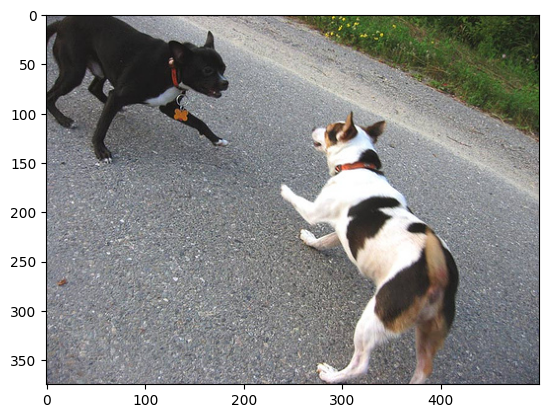

Caption: a black dog is running through the grass


In [81]:
from PIL import Image

# Load image filename from train_data
index = 7
image_file = train_data.iloc[index, 0]  # Get image filename, like '1000268201_693b08cb0e.jpg'

# Construct the full file path to the image (for visualization)
image_path = '/kaggle/working/Flicker8k_Dataset/train/' + image_file

# Retrieve the precomputed image features from your dictionary (train_encoded_images)
image_features = train_encoded_images.get(image_file)  # This should be a 2048-dimensional vector

# Check if the image features exist in the dictionary
if image_features is None:
    print(f"Error: Image features for '{image_file}' not found in train_encoded_images.")
else:
    # Load and display the image for visualization
    x = plt.imread(image_path)
    plt.imshow(x)
    plt.show()

    # Reshape the image features to match the model input (in case it's not already in the correct shape)
    image_features = image_features.reshape((1, 2048))  # Ensure it's a 1D vector with shape (1, 2048)

    # Generate the caption using the precomputed features
    print("Caption:", generateCaption(image_features))


In [ ]:
#train_encoded_images.keys() # are like this '1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg'

# Creating a validation data generator 
This process helps in evaluating the performance of image captioning model on the validation dataset by visualizing the image and the generated caption.

In [82]:
def val_data_generator(data, encoded_images, wordtoidx, max_length, num_photos_per_batch):
    x1, x2, y = [], [], []
    n = 0
    while True:
        for k, caption in enumerate(data['caption']):
            n += 1
            photo = encoded_images[data['id'][k]]

            # Tokenize caption and create sequence
            seq = [wordtoidx[word] for word in word_tokenize(caption) if word in wordtoidx]

            # Generate in_seq, out_seq for the caption sequence
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # Collect the current batch of data
                x1.append(photo)
                x2.append(in_seq)
                y.append(out_seq)

            # Yield data for evaluation
            if n == num_photos_per_batch:
                yield (np.array(x1), np.array(x2)), np.array(y)
                x1, x2, y = [], [], []
                n = 0

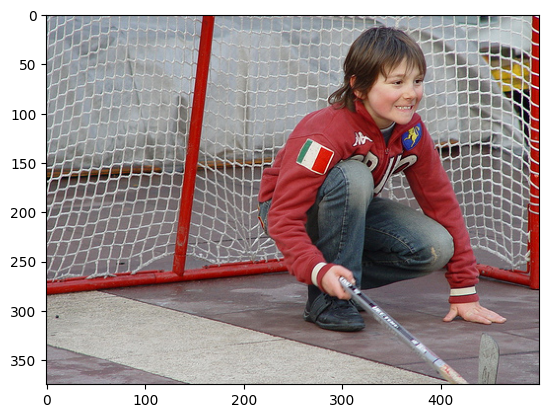

Caption: a man in a red shirt is standing next to a railing


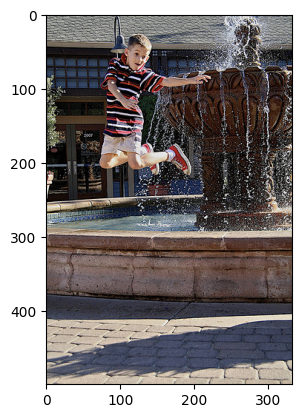

Caption: a man in a red shirt is standing on a beach


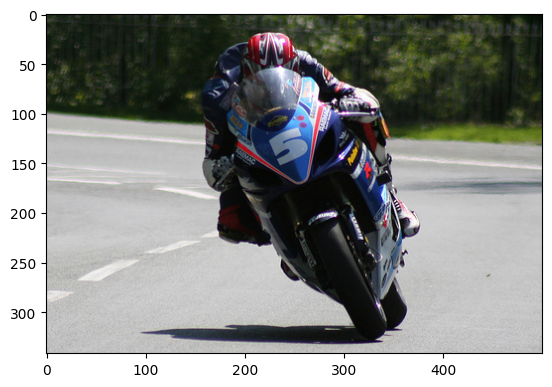

Caption: a man on a motorcycle is riding a bike


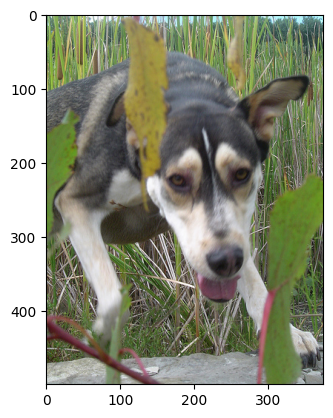

Caption: a dog is running through a field


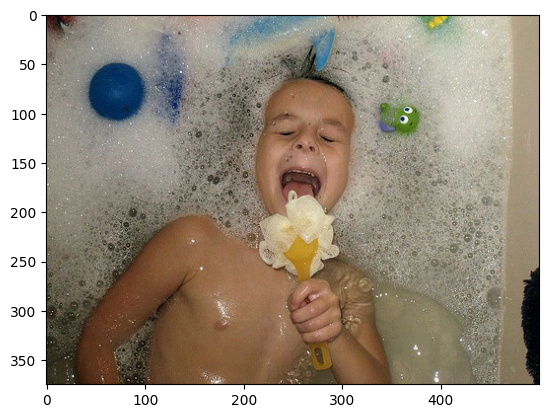

Caption: a young boy is playing in the water


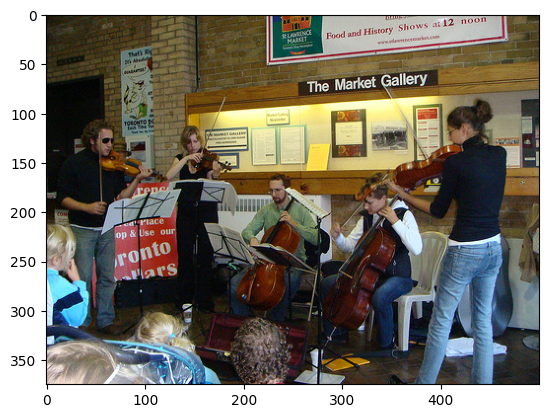

Caption: a man in a white shirt and a woman in a white shirt are riding a vehicle on a campus street


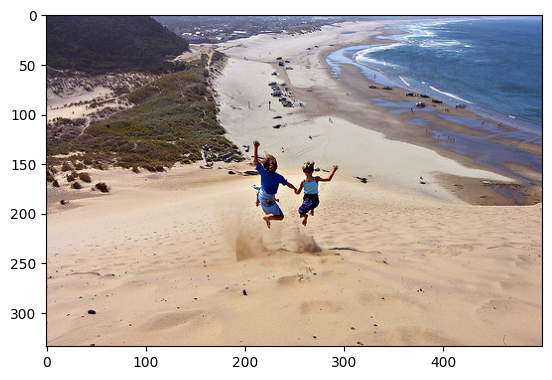

Caption: a man in a black wetsuit is walking along a rocky beach


In [85]:
from PIL import Image
import matplotlib.pyplot as plt

# List of indices
indices = [7, 64, 365, 899, 345, 267,845]

# Loop over each index
for index in indices:
    # Load image filename from val_data
    image_file = val_data.iloc[index, 0]  # Get image filename

    # Construct the full file path to the image (for visualization)
    image_path = '/kaggle/working/Flicker8k_Dataset/val/' + image_file

    # Retrieve the precomputed image features from your dictionary (val_encoded_images)
    image_features = val_encoded_images.get(image_file)  # This should be a 2048-dimensional vector

    # Check if the image features exist in the dictionary
    if image_features is None:
        print(f"Error: Image features for '{image_file}' not found in val_encoded_images.")
    else:
        # Load and display the image for visualization
        x = plt.imread(image_path)
        plt.imshow(x)
        plt.show()

        # Reshape the image features to match the model input (in case it's not already in the correct shape)
        image_features = image_features.reshape((1, 2048))  # Ensure it's a 1D vector with shape (1, 2048)

        # Generate the caption using the precomputed features
        print("Caption:", generateCaption(image_features))


# Creating a test data generator

In [86]:
def test_data_generator(data, encoded_images, wordtoidx, max_length):
    x1, x2, y = [], [], []
    while True:
        for k, caption in enumerate(data['caption']):
            photo = encoded_images[data['id'][k]]

            # Tokenize caption and create sequence
            seq = [wordtoidx[word] for word in word_tokenize(caption) if word in wordtoidx]

            # Generate in_seq, out_seq for the caption sequence
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                # Collect the current batch of data
                x1.append(photo)
                x2.append(in_seq)
                y.append(out_seq)

            # Yield data for evaluation
            yield (np.array(x1), np.array(x2)), np.array(y)

In [87]:

# Prepare the DataFrame to store results
test_results = []

# Define a function to process a single image (extract features and generate caption)
def generate_caption_for_image(image_file):
    # Load the image feature (assuming you have pre-extracted features in 'train_encoded_images')
    image_features = test_encoded_images.get(image_file)
    if image_features is None:
        print(f"Error: Features not found for {image_file}")
        return None

    # Reshape to the correct input shape for the model
    image_features = image_features.reshape((1, 2048))

    # Generate the caption
    caption = generateCaption(image_features)
    
    return caption

# Directory where test images are stored
test_image_dir = '/kaggle/working/Flicker8k_Dataset/test/'

# Iterate over all image files in the test directory
for image_file in tqdm(os.listdir(test_image_dir)):
    if image_file.endswith('.jpg') or image_file.endswith('.jpeg'):  # Assuming .jpg or .jpeg images
        # Generate caption for the image
        caption = generate_caption_for_image(image_file)
        
        if caption is not None:
            # Append the result to the DataFrame list
            test_results.append({'image_id': image_file, 'caption': caption})

# Create a DataFrame to store the results
test_df = pd.DataFrame(test_results)

# Show the first few rows of the DataFrame
test_df.head(10)


100%|██████████| 1000/1000 [11:53<00:00,  1.40it/s]


,image_id,caption
0,2431832075_00aa1a4457.jpg,a young boy is petting a peach bubble
1,2581066814_179d28f306.jpg,a man in a helmet is riding a unicycle down th...
2,2621415349_ef1a7e73be.jpg,a man in a white shirt and a woman in a red sh...
3,114051287_dd85625a04.jpg,a man in a red shirt is sitting on a bench wit...
4,3554634863_5f6f616639.jpg,a man with a red shirt and a cast bag is stand...
5,3523559027_a65619a34b.jpg,a man in a red shirt is standing on a rock
6,751737218_b89839a311.jpg,a man in a red shirt is standing next to a man...
7,3716244806_97d5a1fb61.jpg,a man in a red shirt is standing on a rock ove...
8,2510020918_b2ca0fb2aa.jpg,a young boy is petting a peach
9,1679617928_a73c1769be.jpg,a man is sitting on a bench with a dog


In [88]:
# Optionally, save the DataFrame to a CSV file
test_df.to_csv('generated_captions.csv', index=False)